In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb

%matplotlib inline

In [2]:
#Functions cell

def print_full_rows(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

def print_full_cols(x):
    pd.set_option('display.max_columns', len(x.columns))
    display(x)
    pd.reset_option('display.max_columns')

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', len(x.columns))
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def type_fix(df):
    col='Type'
    df[col].replace({'Single Family':'SingleFamily'},inplace=True)
    for key,val in df[col].value_counts().items():
        if val<100:
            df[col].replace({key:'Other'},inplace=True)
    return 0

def heating_fix(df):
    col = 'Heating'
    df[col] = df[col].str.title()
    for key,value in df[col].value_counts().items():
        if 'Gas' in key or 'Propane' in key:
            df[col].replace({key:'Gas'},inplace=True)
        elif 'Electric' in key or 'Elec' in key:
            df[col].replace({key:'Electric'},inplace=True)
        elif 'Radiant' in key:
            df[col].replace({key:'Radiant'},inplace=True)
        elif 'Furnace' in key:
            df[col].replace({key:'Furnace'},inplace=True)
        elif 'Baseboard' in key:
            df[col].replace({key:'Baseboard'},inplace=True)
        elif 'Fireplace' in key:
            df[col].replace({key:'Fireplace'},inplace=True)
        elif 'Solar' in key:
            df[col].replace({key:'Solar'},inplace=True)
        elif 'Central' in key:
            df[col].replace({key:'Central'},inplace=True)
        elif 'None' in key:
            df[col].replace({key:'None'},inplace=True)
        elif 'Heat Pump' in key:
            df[col].replace({key:'Heat Pump'},inplace=True)
        elif 'Forced Air' in key:
            df[col].replace({key:'Forced Air'},inplace=True)
        else:
            df[col].replace({key:'Other'}, inplace=True)
    return 0

def cooling_fix(df):
    col = 'Cooling'
    df[col] = df[col].str.title()
    for key,value in df[col].value_counts().items():
        if 'Central' in key or 'Air Conditioning' in key:
            df[col].replace({key:'Central AC'},inplace=True)
        elif 'Ceiling Fan' in key:
            df[col].replace({key:'Ceiling Fan'},inplace=True)
        elif 'Unit' in key or 'Wall' in key:
            df[col].replace({key:'Wall/Window Unit'},inplace=True)
        elif 'Evaporative' in key:
            df[col].replace({key:'Evaporative'},inplace=True)
        else:
            df[col].replace({key:'Other'},inplace=True)
    return 0

def parking_fix(df):
    col = 'Parking'
    df[col] = df[col].str.title()
    for key,value in df[col].value_counts().items():
        if 'None' in key or '0' in key or 'On Street' in key or 'On-Street' in key or 'No Garage' in key:
            df[col].replace({key:'None'},inplace=True)
        elif 'Covered' in key:
            df[col].replace({key:'Covered Garage'},inplace=True)
        elif 'Attached' in key:
            df[col].replace({key:'Attached Garage'},inplace=True)
        elif 'Detached' in key:
            df[col].replace({key:'Detached Garage'},inplace=True)
        elif 'Carport' in key:
            df[col].replace({key:'Carport Garage'},inplace=True)
        elif 'Driveway' in key:
            df[col].replace({key:'Driveway Garage'},inplace=True)
        elif 'Off Street' in key or 'Off-Street' in key:
            df[col].replace({key:'Off Street Garage'},inplace=True)
        elif 'Assigned' in key:
            df[col].replace({key:'Assigned Garage'},inplace=True)             
        elif 'On Site' in key:
            df[col].replace({key:'On Site Garage'},inplace=True)  
        elif 'Two Door' in key or 'One Door' in key or 'Single' in key or 'Three' in key:
            df[col].replace({key:'One, Two or Three Door Garage'},inplace=True) 
        else:
            df[col].replace({key:'Other'},inplace=True) 
            
    return 0

def bedroom_fix(df):
    col = 'Bedrooms'
    for key,value in df[col].value_counts().items():
        if key.isnumeric():
            df[col].replace({key:int(key)},inplace=True)
        else:
            count = 0
            count += key.count('Suite') +key.count('Bedroom')
            df[col].replace({key:count},inplace=True)
    return 0

def region_fix(df):
    col = 'Region'
    th = 100 #If there aren't 100 houses sold in the region, we aggregate them as Other
    for key,value in df[col].value_counts().items():
        if value<th:
            df[col].replace({key:'Other'},inplace=True)

def top_of_the_feat(df,col):
    #This returns a list with the most common categories in a feature (over 100 residencies with it)
    import re

    delimiters = ', ', ' / ', '/', '&','-'
    regex_pattern = '|'.join(map(re.escape, delimiters))
    top_floorings = ['other']
    floor_dict = {}
    for key, value in df[col].value_counts().items():
        
        new_list = re.split(regex_pattern,key.title())
        for elem in new_list:
            # print(elem)
            elem = elem.lower().replace(" ", "")
            # print(elem)
            if elem not in floor_dict.keys():
                floor_dict[elem]=0
            else:
                floor_dict[elem]+=1

    for key, value in pd.Series(floor_dict).sort_values(ascending=False).items():
        if value<100:
            break
        top_floorings.append(key.lower().replace(" ", ""))
    return top_floorings

def top_of_the_feat_encoder(df,col,top_feats):
    
    import re
    
    delimiters = ', ', ' / ', '/', '&','-'
    regex_pattern = '|'.join(map(re.escape, delimiters))
    
    for key, value in df[col].value_counts().items():
        new_list = []
        split_floorings = re.split(regex_pattern,key)
        for i in range(len(split_floorings)):
            # print(split_floorings[i])
            elem = split_floorings[i].lower().replace(" ", "")
            # print(elem)
            # if 'Garbage' in split_floorings[i] :
                # print(split_floorings[i])
                # print(split_floorings[i].replace(" ", ""))
            if elem not in top_feats:
                # if 'Garbage' in split_floorings[i] :
                    # print(split_floorings[i],1)
                if new_list.count('Other')<1:
                    new_list.append('Other')
            else:
                # if 'Garbage' in split_floorings[i] :
                    # print(split_floorings[i],2)
                if elem not in new_list:
                    new_list.append(elem)
        df[col].replace({key:', '.join(sorted(new_list))},inplace=True)

    column_names = [col + '_'+ u.lower().replace(" ", "") for u in top_feats]
    df_encoded = pd.DataFrame(data=np.zeros((len(df),len(top_feats))),columns=column_names)
    
    i=0
    for entry in df[col]:
        if type(entry) != type('a'):
            continue
        entry = re.split(regex_pattern, entry)
        for elem in entry:
            df_encoded[col + '_'+ elem.lower().replace(" ", "")].iloc[i] = 1
        i+=1
    df_encoded.drop(col + '_' + top_feats[0].lower().replace(" ",''),axis=1,inplace=True)
    df.drop(col,axis=1,inplace=True)
    df = pd.concat([df,df_encoded],axis=1)
    
    return df

def listedon_fix(df):
    col = 'Listed On'
    df[col] = pd.to_datetime(df[col])
    df[col] = (df[col] - df[col].max()).astype(str)
    for i in range(len(df[col])):
        df[col].iloc[i] = np.abs(int(df[col].iloc[i][:-5]))
    df[col].astype(float)

def state_fix(df):
    col = 'State'
    df.replace({'CA':1,'AZ':0}, inplace=True)
    df.rename({'State':'California'}, inplace=True)

def delete_columns(df):
    columns = ['Id','Address','Summary','Elementary School', 'Middle School', 
               'High School', 'Heating features', 'Cooling features', 'Parking features', 
               'City', 'Zip','Last Sold On']
    df.drop(columns, axis=1, inplace=True)

In [3]:
df = pd.read_csv('data/train.csv')
df.rename(columns={'Appliances included':'Appliances','Laundry features':'Laundry'},inplace=True)
print_full_cols(df)

Id                   Address  Sold Price  \
0          0               540 Pine Ln   3825000.0   
1          1            1727 W 67th St    505000.0   
2          2            28093 Pine Ave    140000.0   
3          3         10750 Braddock Dr   1775000.0   
4          4         7415 O Donovan Rd   1175000.0   
...      ...                       ...         ...   
47434  47434        2409 Florence Blvd    159000.0   
47435  47435  1085 Tasman Dr SPACE 818    255000.0   
47436  47436   1338 N Orange Grove Ave   2300000.0   
47437  47437         9996 Fan Shell Ln    500000.0   
47438  47438           4552 Howard Ave    760000.0   

                                                 Summary                Type  \
0      540 Pine Ln, Los Altos, CA 94022 is a single f...        SingleFamily   
1      HURRY, HURRY.......Great house 3 bed and 2 bat...        SingleFamily   
2      'THE PERFECT CABIN TO FLIP!  Strawberry deligh...        SingleFamily   
3      Rare 2-story Gated 5 bedroom Modern Mediterran...        SingleFamily   
4      Beautiful 200 acre ranch land with several pas...          VacantLand   
...                                                  ...                 ...   
47434  2409 Florence Blvd, Blythe, CA 92225 is a sing...        SingleFamily   
47435  LOOK AT THIS PRICE $30k PRICE REDUCTION, USE T...  MobileManufactured   
47436  Beautifully restored historic Colonial Revival...        SingleFamily   
47437  Great opportunity to live in the friendly gate...        SingleFamily   
47438  This fantastic single story home is on a large...        SingleFamily   

       Year built                                       Heating  \
0          1969.0  Heating - 2+ Zones, Central Forced Air - Gas   
1          1926.0                                   Combination   
2          1958.0                                    Forced air   
3          1947.0                                       Central   
4             NaN                                           NaN   
...           ...                                           ...   
47434      1965.0                                       Central   
47435      1999.0                       Central Forced Air, Gas   
47436      1919.0                                       Central   
47437      2017.0                                       Central   
47438      1948.0                                           NaN   

                                                 Cooling  \
0        Multi-Zone, Central AC, Whole House / Attic Fan   
1      Wall/Window Unit(s), Evaporative Cooling, See ...   
2                                                    NaN   
3                                            Central Air   
4                                                    NaN   
...                                                  ...   
47434                                        Central Air   
47435                                         Central AC   
47436                                        Central Air   
47437                                        Central Air   
47438                                                NaN   

                                             Parking      Lot  \
0                 Garage, Garage - Attached, Covered      1.0   
1                           Detached Carport, Garage   4047.0   
2                                           0 spaces   9147.0   
3      Detached Carport, Driveway, Garage - Two Door      NaN   
4                                           0 spaces      NaN   
...                                              ...      ...   
47434                               Carport, Covered  20908.8   
47435                                        Carport      NaN   
47436                                       Driveway   6756.0   
47437    Garage, Carport, Garage - Attached, Covered   5945.0   
47438                              Garage - Attached   8250.0   

                                                Bedrooms  Bathrooms  \
0      Ground Floor Be

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47085 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40587 non-null  object 
 7   Cooling                      26745 non-null  object 
 8   Parking                      46065 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

Lots of columuns with missing data.

In [5]:
df.describe()

Id    Sold Price    Year built           Lot     Bathrooms  \
count  47439.000000  4.743900e+04  46394.000000  3.325800e+04  43974.000000   
mean   23719.000000  1.296050e+06   1956.634888  2.353383e+05      2.355642   
std    13694.604047  1.694452e+06    145.802456  1.192507e+07      1.188805   
min        0.000000  1.005000e+05      0.000000  0.000000e+00      0.000000   
25%    11859.500000  5.650000e+05   1946.000000  4.991000e+03      2.000000   
50%    23719.000000  9.600000e+05   1967.000000  6.502000e+03      2.000000   
75%    35578.500000  1.525000e+06   1989.000000  1.045400e+04      3.000000   
max    47438.000000  9.000000e+07   9999.000000  1.897474e+09     24.000000   

       Full bathrooms  Total interior livable area  Total spaces  \
count    39574.000000                 4.491300e+04  46523.000000   
mean         2.094961                 5.774587e+03      1.567117   
std          0.963320                 8.324363e+05      9.011608   
min          1.000000                 1.000000e+00    -15.000000   
25%          2.000000                 1.187000e+03      0.000000   
50%          2.000000                 1.566000e+03      1.000000   
75%          2.000000                 2.142000e+03      2.000000   
max         17.000000                 1.764164e+08   1000.000000   

       Garage spaces  Elementary School Score  Elementary School Distance  \
count   46522.000000             42543.000000                42697.000000   
mean        1.491746                 5.720824                    1.152411   
std         8.964319                 2.103350                    2.332367   
min       -15.000000                 1.000000                    0.000000   
25%         0.000000                 4.000000                    0.300000   
50%         1.000000                 6.000000                    0.500000   
75%         2.000000                 7.000000                    1.000000   
max      1000.000000                10.000000                   57.200000   

       Middle School Score  Middle School Distance  High School Score  \
count         30734.000000            30735.000000       42220.000000   
mean              5.317206                1.691593           6.134344   
std               2.002768                2.462879           1.984711   
min               1.000000                0.000000           1.000000   
25%               4.000000                0.600000           5.000000   
50%               5.000000                1.000000           6.000000   
75%               7.000000                1.800000           8.000000   
max               9.000000               57.200000          10.000000   

       High School Distance  Tax assessed value  Annual tax amount  \
count          42438.000000        4.378700e+04       43129.000000   
mean               2.410366        7.863118e+05        9956.843817   
std                3.596120        1.157796e+06       13884.254976   
min                0.000000        0.000000e+00           0.000000   
25%                0.800000        2.549615e+05        3467.000000   
50%                1.300000        5.475240e+05        7129.000000   
75%                2.400000        9.371625e+05       12010.000000   
max               73.900000        4.590000e+07      552485.000000   

       Listed Price  Last Sold Price           Zip  
count  4.743900e+04     2.967300e+04  47439.000000  
mean   1.315890e+06     8.078537e+05  93279.178587  
std    2.628695e+06     1.177903e+06   2263.459104  
min    0.000000e+00     0.000000e+00  85611.000000  
25%    5.745000e+05     3.350000e+05  90220.000000  
50%    9.490000e+05     5.980000e+05  94114.000000  
75%    1.498844e+06     9.500000e+05  95073.000000  
max    4.025320e+08     9.000000e+07  96155.000000

In [6]:
df.isna().sum()

Id                                 0
Address                            0
Sold Price                         0
Summary                          354
Type                               0
Year built                      1045
Heating                         6852
Cooling                        20694
Parking                         1374
Lot                            14181
Bedrooms                        2872
Bathrooms                       3465
Full bathrooms                  7865
Total interior livable area     2526
Total spaces                     916
Garage spaces                    917
Region                             2
Elementary School               4742
Elementary School Score         4896
Elementary School Distance      4742
Middle School                  16704
Middle School Score            16705
Middle School Distance         16704
High School                     5000
High School Score               5219
High School Distance            5001
Flooring                       11569
H

In [7]:
print_full_rows(df['Type'].value_counts())

Type
SingleFamily                                                                                           31324
Condo                                                                                                   8094
Townhouse                                                                                               2545
Unknown                                                                                                 1597
MultiFamily                                                                                             1292
MobileManufactured                                                                                      1002
VacantLand                                                                                               810
Single Family                                                                                            177
Apartment                                                                                                169
Residential Lo

In [8]:
print_full_rows(df['Heating'].value_counts())

Heating
Central                                                                                                                        9593
Central Forced Air                                                                                                             5394
Central Forced Air - Gas                                                                                                       3528
Forced Air                                                                                                                     2532
Wall Furnace                                                                                                                   1915
Other                                                                                                                          1464
Forced air, Gas                                                                                                                1332
Forced air                                                          

In [9]:
print_full_rows(df['Cooling'].value_counts())

Cooling
Central Air                                                                                                                                                  8875
Central AC                                                                                                                                                   6066
Central                                                                                                                                                      2756
Ceiling Fan                                                                                                                                                  1137
Ceiling Fan, Central AC                                                                                                                                       901
Other                                                                                                                                                         898
Wall/Window Unit(s) 

In [10]:
print_full_rows(df['Parking'].value_counts())

Parking
Garage, Garage - Attached, Covered                                                                                                                                                                                                                                          10392
0 spaces                                                                                                                                                                                                                                                                     3202
Garage, Garage - Attached                                                                                                                                                                                                                                                    2351
Garage                                                                                                                                                                    

In [11]:
print_full_rows(df['Bedrooms'].value_counts())

Bedrooms
3                                                                                                                                                                                                                                                14943
2                                                                                                                                                                                                                                                 9772
4                                                                                                                                                                                                                                                 7073
1                                                                                                                                                                                                                                                 2313
5  

In [12]:
print_full_rows(df['Region'].value_counts())

Region
Los Angeles                 10338
San Jose                     6740
San Francisco                4973
San Mateo                     828
Sunnyvale                     804
Santa Clara                   791
Santa Cruz                    786
Morgan Hill                   584
Los Gatos                     579
Gilroy                        520
Mountain View                 509
Compton                       473
Milpitas                      456
Aptos                         440
Redwood City                  437
Palo Alto                     414
West Hollywood                403
San Carlos                    358
Culver City                   350
Menlo Park                    337
Beverly Hills                 336
Los Altos                     333
Sacramento                    327
South San Francisco           323
Watsonville                   307
Cupertino                     300
Pacifica                      295
Saratoga                      283
San Bruno                     263
Scotts 

In [13]:
print_full_rows(df['Elementary School'].value_counts())

Elementary School
Laurel Elementary School                                                                     339
Sherman Elementary School                                                                    313
Daniel Webster Elementary School                                                             308
Kenter Canyon Elementary School                                                              299
Cabrillo Elementary School                                                                   290
Gardner Street Elementary School                                                             281
Warner Avenue Elementary School                                                              270
Rooftop Elementary School                                                                    252
McKinley Elementary School                                                                   247
Merritt Trace Elementary School                                                              240
West Hollywo

In [14]:
print_full_rows(df['Elementary School Score'].value_counts())

Elementary School Score
6.0     6393
5.0     6370
4.0     6197
7.0     6124
8.0     5535
9.0     4734
3.0     4126
2.0     2631
1.0      371
10.0      62
Name: count, dtype: int64

In [15]:
print_full_rows(df['Elementary School Distance'].value_counts())

Elementary School Distance
0.3     5534
0.4     5104
0.2     4787
0.5     4350
0.6     3251
0.7     2593
0.1     2433
0.8     2056
0.9     1471
1.0     1167
1.1      847
1.2      721
1.3      674
1.4      585
1.5      473
1.8      401
1.6      396
1.7      384
1.9      338
2.0      242
2.1      225
2.4      211
2.3      208
2.2      195
2.5      155
2.6      148
2.8      122
3.5      117
2.7      117
0.0      116
3.1      112
3.0      108
3.3      105
3.2      103
2.9       98
3.7       88
3.6       87
3.8       87
3.4       85
3.9       76
4.0       72
4.3       71
4.4       57
4.8       55
4.2       53
4.5       50
4.9       49
6.2       47
5.9       45
4.6       42
4.1       42
5.2       42
5.3       41
4.7       38
6.3       37
6.1       36
5.0       36
5.6       35
5.8       35
5.5       35
5.4       33
6.6       33
5.1       33
6.0       32
7.4       31
6.9       31
5.7       29
7.3       29
7.2       27
7.0       26
6.8       25
7.8       23
6.5       22
11.1      22
9.1       2

In [16]:
print_full_rows(df['Flooring'].value_counts())

Flooring
Wood                                                                       4021
Hardwood                                                                   2423
Tile, Hardwood                                                             1774
Laminate                                                                   1769
Tile, Wood                                                                 1719
Tile, Hardwood, Carpet                                                     1168
Wood, Tile                                                                 1076
Tile, Laminate                                                              932
Carpet, Wood                                                                923
Tile, Carpet                                                                894
Carpet                                                                      839
Carpet, Tile                                                                732
Tile                           

In [17]:
print_full_rows(df['Heating features'].value_counts())

Heating features
Forced air, Gas                                                                                  8331
Central                                                                                          8035
Forced air                                                                                       6603
Other                                                                                            1713
Wall Furnace                                                                                     1234
Forced Air                                                                                       1025
Forced air, Electric                                                                              829
Central, Gas                                                                                      724
Wall                                                                                              493
Radiant                                                          

In [18]:
print_full_rows(df['Cooling features'].value_counts())

Cooling features
Central                                                                                                                                                      12373
Central Air                                                                                                                                                   7321
Other                                                                                                                                                         1019
Wall                                                                                                                                                           667
Wall/Window Unit(s)                                                                                                                                            663
Central, Solar                                                                                                                                                 270
Evapo

In [19]:
print_full_rows(df['Appliances'].value_counts())

Appliances
Dishwasher, Dryer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer                                                                                                                                                                                                                                                                                                                 2003
Dishwasher, Dryer, Freezer, Garbage disposal, Microwave, Range / Oven, Refrigerator, Washer                                                                                                                                                                                                                                                                                                        1335
Dryer, Washer                                                                                                                                                                                                

In [20]:
print_full_rows(df['Laundry'].value_counts())

Laundry
Inside                                                                                                                      3901
In Garage                                                                                                                   3420
Laundry Closet                                                                                                              1671
Laundry Room                                                                                                                1480
Washer / Dryer                                                                                                              1318
Washer / Dryer, Inside                                                                                                      1298
Inside Room                                                                                                                  991
In Unit                                                                                  

In [21]:
print_full_rows(df['Parking features'].value_counts())

Parking features
Garage, Garage - Attached, Covered                                                                                                                                                                                                                                          10481
Garage, Garage - Attached                                                                                                                                                                                                                                                    2362
Garage                                                                                                                                                                                                                                                                       2107
Garage - Attached                                                                                                                                                

In [22]:
print_full_rows(df['Listed On'].value_counts())

Listed On
2020-10-16    286
2020-09-18    282
2020-10-02    279
2020-09-25    259
2020-10-09    257
2020-10-23    254
2020-08-14    253
2020-09-11    248
2020-08-07    247
2020-09-04    245
2020-10-15    245
2020-10-01    242
2020-07-10    237
2020-09-24    233
2020-06-12    229
2020-09-10    227
2020-10-08    225
2020-08-28    224
2020-10-22    224
2020-07-24    224
2020-08-13    221
2020-08-21    219
2020-10-30    218
2020-07-31    215
2020-07-16    213
2020-09-17    212
2020-10-07    212
2020-09-16    211
2020-05-15    210
2020-08-20    209
2020-06-19    208
2020-10-29    207
2020-09-09    207
2020-09-23    207
2020-10-21    207
2020-06-26    206
2020-07-17    205
2020-09-02    204
2020-11-06    204
2020-09-03    203
2020-05-22    197
2020-08-06    197
2020-07-30    195
2020-09-08    194
2020-11-05    192
2020-07-15    190
2020-06-05    190
2020-06-18    189
2020-07-06    189
2020-07-09    189
2020-09-30    188
2020-03-12    188
2020-08-26    187
2020-10-13    187
2020-10-14    186


In [23]:
print_full_rows(df['Last Sold On'].value_counts())
df['Last Sold On'].isna().sum()

Last Sold On
2017-06-30    34
2015-02-27    31
2016-09-30    31
2019-08-30    29
2016-07-29    29
2017-12-29    29
2017-05-26    29
2017-09-29    28
2013-08-30    28
2017-06-09    27
2018-05-25    27
2019-04-30    27
2018-05-31    25
2017-09-15    25
2016-10-28    25
2019-05-31    25
2019-10-18    24
2019-11-08    24
2015-12-18    24
2018-04-27    24
2014-05-30    23
2015-05-15    23
2016-05-20    23
2019-10-11    23
2019-06-28    23
2018-06-15    23
2019-12-20    22
2016-07-01    22
2014-08-29    22
2015-09-04    22
2016-11-30    22
2015-06-05    22
2012-08-31    22
2019-11-19    22
2014-09-30    22
2016-08-12    22
2015-07-24    22
2016-10-21    21
2014-11-26    21
2018-06-08    21
2017-09-08    21
2018-06-29    21
2019-03-29    21
2018-06-05    21
2016-07-22    21
2015-05-22    20
2019-12-31    20
2020-02-28    20
2016-03-25    20
2015-12-23    20
2017-08-11    20
2013-06-14    20
2018-04-13    20
2016-07-15    20
2017-08-30    20
2016-11-22    20
2016-06-29    20
2017-06-23    20
2

17766

In [24]:
print_full_rows(df['City'].value_counts())


City
Los Angeles                 10246
San Jose                     6503
San Francisco                4974
San Mateo                    1033
Santa Clara                  1025
Sunnyvale                     804
Santa Cruz                    796
Los Gatos                     626
Morgan Hill                   583
Redwood City                  544
Gilroy                        521
Mountain View                 509
Palo Alto                     500
Compton                       482
Milpitas                      456
Aptos                         440
Los Altos                     429
Culver City                   406
West Hollywood                388
Watsonville                   380
San Carlos                    358
Beverly Hills                 336
Menlo Park                    336
Sacramento                    332
South San Francisco           323
Cupertino                     300
Pacifica                      295
Saratoga                      283
San Bruno                     263
Scotts Va

In [25]:
print_full_rows(df['State'].value_counts())


State
CA    46991
AZ      448
Name: count, dtype: int64

# We need to impute or clean the data in each of those features

In [26]:
type_fix(df)
heating_fix(df)
cooling_fix(df)
parking_fix(df)
bedroom_fix(df)
region_fix(df)
top_floorings= top_of_the_feat(df,'Flooring')
df = top_of_the_feat_encoder(df,'Flooring',top_floorings)
top_appliances = top_of_the_feat(df,'Appliances')
df = top_of_the_feat_encoder(df,'Appliances', top_appliances)
top_laundry = top_of_the_feat(df,'Laundry')
df = top_of_the_feat_encoder(df,'Laundry', top_laundry)
listedon_fix(df)
state_fix(df)
delete_columns(df)

/tmp/ipykernel_323893/2346732002.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[col + '_'+ elem.lower().replace(" ", "")].iloc[i] = 1
/tmp/ipykernel_323893/2346732002.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[col + '_'+ elem.lower().replace(" ", "")].iloc[i] = 1
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

/

In [27]:
print_full_rows(df['Type'].value_counts())

Type
SingleFamily          31501
Condo                  8094
Townhouse              2545
Unknown                1597
MultiFamily            1292
MobileManufactured     1002
VacantLand              810
Other                   429
Apartment               169
Name: count, dtype: int64

In [28]:
print_full_rows(df['Type'].value_counts())

Type
SingleFamily          31501
Condo                  8094
Townhouse              2545
Unknown                1597
MultiFamily            1292
MobileManufactured     1002
VacantLand              810
Other                   429
Apartment               169
Name: count, dtype: int64

In [29]:
print_full_rows(df['Heating'].value_counts())

Heating
Central       15816
Gas           11177
Forced Air     3957
Other          2675
Furnace        2646
Electric       1616
Fireplace       874
Radiant         776
Baseboard       455
Heat Pump       226
None            225
Solar           144
Name: count, dtype: int64

In [30]:
print_full_rows(df['Cooling'].value_counts())

Cooling
Central AC          21526
Other                1814
Ceiling Fan          1566
Wall/Window Unit     1538
Evaporative           301
Name: count, dtype: int64

In [31]:
print_full_rows(df['Parking'].value_counts())

Parking
Covered Garage                   17882
Attached Garage                   7854
None                              4839
Other                             4451
Driveway Garage                   3775
One, Two or Three Door Garage     1731
Carport Garage                    1552
On Site Garage                    1406
Detached Garage                   1236
Assigned Garage                    972
Off Street Garage                  367
Name: count, dtype: int64

In [32]:
print_full_rows(df['Bedrooms'].value_counts())

Bedrooms
3.0     15640
2.0     11386
4.0      7292
1.0      5934
5.0      2041
0.0      1467
6.0       475
7.0       143
8.0        72
10.0       32
9.0        31
12.0       13
16.0        7
11.0        6
20.0        4
18.0        4
19.0        3
24.0        3
14.0        2
15.0        2
21.0        2
22.0        1
27.0        1
26.0        1
29.0        1
31.0        1
30.0        1
42.0        1
40.0        1
Name: count, dtype: int64

In [33]:
print_full_cols(df)

Sold Price                Type  Year built     Heating  \
0       3825000.0        SingleFamily      1969.0         Gas   
1        505000.0        SingleFamily      1926.0       Other   
2        140000.0        SingleFamily      1958.0  Forced Air   
3       1775000.0        SingleFamily      1947.0     Central   
4       1175000.0          VacantLand         NaN         NaN   
...           ...                 ...         ...         ...   
47434    159000.0        SingleFamily      1965.0     Central   
47435    255000.0  MobileManufactured      1999.0         Gas   
47436   2300000.0        SingleFamily      1919.0     Central   
47437    500000.0        SingleFamily      2017.0     Central   
47438    760000.0        SingleFamily      1948.0         NaN   

                Cooling          Parking      Lot  Bedrooms  Bathrooms  \
0            Central AC   Covered Garage      1.0       3.0        0.0   
1      Wall/Window Unit  Detached Garage   4047.0       3.0        2.0   
2                   NaN             None   9147.0       2.0        3.0   
3            Central AC  Detached Garage      NaN       5.0        3.0   
4                   NaN             None      NaN       NaN        NaN   
...                 ...              ...      ...       ...        ...   
47434        Central AC   Covered Garage  20908.8       3.0        2.0   
47435        Central AC   Carport Garage      NaN       3.0        2.0   
47436        Central AC  Driveway Garage   6756.0       3.0        2.0   
47437        Central AC   Covered Garage   5945.0       3.0        3.0   
47438               NaN  Attached Garage   8250.0       2.0        1.0   

       Full bathrooms  Total interior livable area  Total spaces  \
0                 NaN                          1.0           0.0   
1                 2.0                        872.0           1.0   
2                 1.0                       1152.0           0.0   
3                 3.0                       2612.0           0.0   
4                 NaN                          NaN           NaN   
...               ...                          ...           ...   
47434             2.0                       1432.0           2.0   
47435             2.0                       1560.0           0.0   
47436             2.0                       1860.0           0.0   
47437             2.0                       2125.0           4.0   
47438             1.0                       1112.0           1.0   

       Garage spaces          Region  Elementary School Score  \
0                0.0       Los Altos                      7.0   
1                1.0     Los Angeles                      3.0   
2                0.0           Other                      NaN   
3                0.0     Culver City                      9.0   
4                NaN           Other                      6.0   
...              ...             ...                      ...   
47434            2.0           Other                      3.0   
47435            0.0       Sunnyvale                      5.0   
47436            0.0  West Hollywood                      7.0   
47437            4.0           Other                      7.0   
47438            1.0           Other                      9.0   

       Elementary School Distance  Middle School Score  \
0                             0.4                  NaN   
1                             0.8                  2.0   
2                             NaN                  NaN   
3                             0.2                  7.0   
4                             8.5                  5.0   
...                           ...                  ...   
47434                         2.4                  NaN   
47435                         2.4                  6.0   
47436                         0.6                  3.0   
47437                         0.5                  7.0   
47438                         0.7                  8.0   

       Middle School Distance  High School

# Building Pipelines

In [34]:
X = df.drop('Sold Price',axis=1)
y = df['Sold Price']

In [35]:
nominal_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse_output = False, drop = 'first', handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

nominal_noohe_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotnorm', MaxAbsScaler())
])
numeric_pipeline = Pipeline([('numimputer', SimpleImputer()), ('numnorm', StandardScaler())])

In [36]:
nominal_columns = ['Type','Heating','Cooling','Parking','Region']
noohe_columns = X.columns[24:]
numeric_columns = [column for column in X.columns if (column not in nominal_columns) and (column not in noohe_columns)]
numeric_columns

['Year built',
 'Lot',
 'Bedrooms',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold Price']

In [37]:
ct = ColumnTransformer([
    ('nominalpipe',nominal_pipeline,nominal_columns),
    ('noohepipe', nominal_noohe_pipeline,noohe_columns),
    ('numericpipe', numeric_pipeline, numeric_columns)
])

In [38]:
ct

ColumnTransformer(transformers=[('nominalpipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 ['Type', 'Heating', 'Cooling', 'Parking',
                                  'Region']),
                                ('noohepipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(st...
                                                 ('numnorm',
                                                  StandardScaler())]),
                                 ['Year built', 'Lot', 'Bedrooms', 'Bathrooms',
                                  'Full bathrooms',
                                  'Total interior livable area', 'Total spaces',
                                  'Garage spaces', 'Elementary School Score',
                                  'Elementary School Distance',
                                  'Middle School Score',
                                  'Middle School Distance', 'High School Score',
                                  'High School Distance', 'Tax assessed value',
                                  'Annual tax amount', 'Listed On',
                                  'Listed Price', 'Last Sold Price'])])

# Scoring
For the scoring we use a special RMSE funtion where we subtract the logarithm of the observed price from the logarithm of the predicted price on the following form.

In [39]:
def logrmse(y, y_pred):
    from numpy import log
    n = len(y)
    log1 = log((y_pred))
    log2 = log(y)
    difference = log1 - log2
    return ((1/n)*sum(np.power(difference,2)))**0.5
    
logrmse_scorer = make_scorer(logrmse, greater_is_better=False)

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. However if a model has a problem with this metric (meaning its predicting y_pred<=0) we use the negative RMSE as a score.

# Train and test sets

A test set has been given for the final score but we need to use part of the train set to test our model.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Baseline model - Linear Regression

In [41]:
lr = LinearRegression()

In [42]:
lr_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr)
    
])
lr_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                  ['Year built', 'Lot',
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression())])

In [43]:
lr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False]}

In [44]:
gs_lr = GridSearchCV(estimator=lr_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error')
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [45]:
gs_lr.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepi...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [46]:
gs_lr.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [47]:
best_estimator_lr = gs_lr.best_estimator_

In [48]:
best_estimator_lr.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [49]:
y_pred_lr = best_estimator_lr.predict(X_test)

(-1000000.0, 15000000.0)

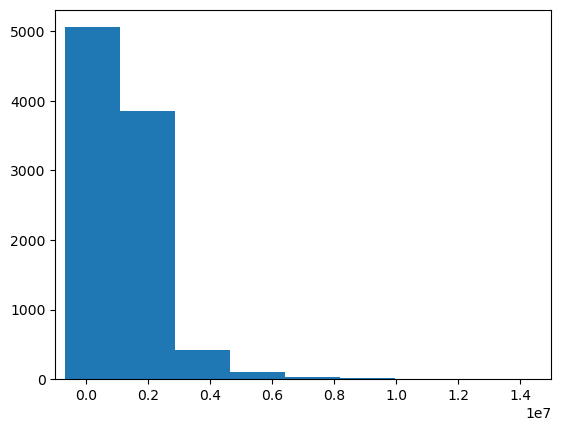

In [50]:
plt.hist(y_pred_lr,bins=2000)
plt.xlim(-1000000,15000000)

(0.0, 15000000.0)

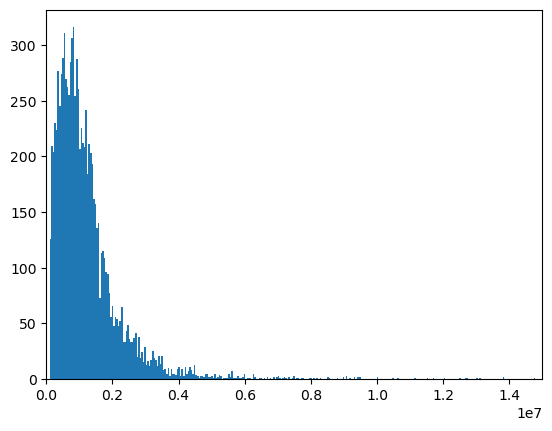

In [51]:
plt.hist(y_test,bins=1000)
plt.xlim(0,15000000)

In [52]:
logrmse_lr,rmse_lr = logrmse(y_test,y_pred_lr), mean_squared_error(y_test,y_pred_lr,squared=False)
logrmse_lr,rmse_lr

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 36429774.84452176)

As we can see this model fails to come up with only positive answers. This might be caused by the presence of outliers in our dataset.

# 1st Model - Linear Regression with 2 estimators

<Axes: >

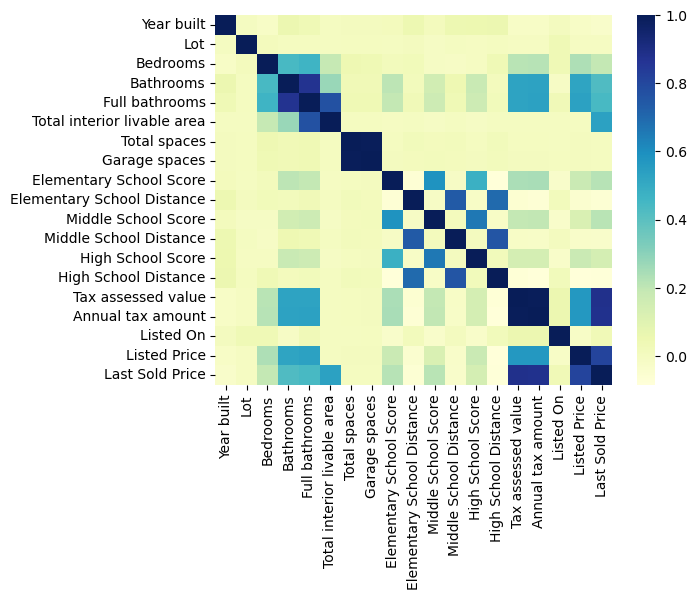

In [53]:
corr = df[numeric_columns].corr()
sns.heatmap(corr,cmap="YlGnBu")

In [54]:
corr_columns = [column for column in df.columns if (column not in nominal_columns)]
df[corr_columns]
corr = df[corr_columns].corr()['Sold Price']
corr.sort_values(ascending=False).head(15)

Sold Price                 1.000000
Annual tax amount          0.746221
Tax assessed value         0.743233
Last Sold Price            0.706779
Listed Price               0.612651
Full bathrooms             0.544245
Bathrooms                  0.516208
Elementary School Score    0.275555
Middle School Score        0.244285
Bedrooms                   0.230111
High School Score          0.191616
State                      0.057527
Appliances_dishwasher      0.032614
Appliances_refrigerator    0.031672
Appliances_microwave       0.029996
Name: Sold Price, dtype: float64

We plan to divide the dataset into 2: one for expensive houses (over 4M), one for cheaper houses (under 4M). For that we use two features that do not have missing features all together: Tax assessed value and Listed Price. We first try using Tax assessed value and if the value is nan we use Listed Price.

In [55]:
len(df[(df['Tax assessed value'].isna()) & (df['Listed Price'].isna())])

0

(0.0, 10000000.0)

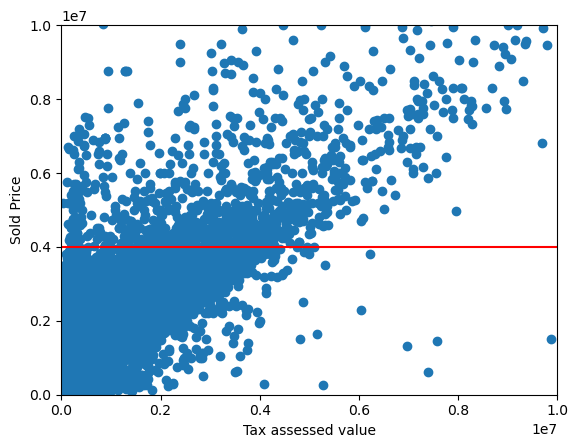

In [56]:
plt.scatter(df['Tax assessed value'],df['Sold Price'])
plt.hlines(y=4000000,xmin=0,xmax=10000000,colors='r')
plt.xlabel('Tax assessed value')
plt.ylabel('Sold Price')
plt.xlim(0,10000000)
plt.ylim(0,10000000)

(0.0, 10000000.0)

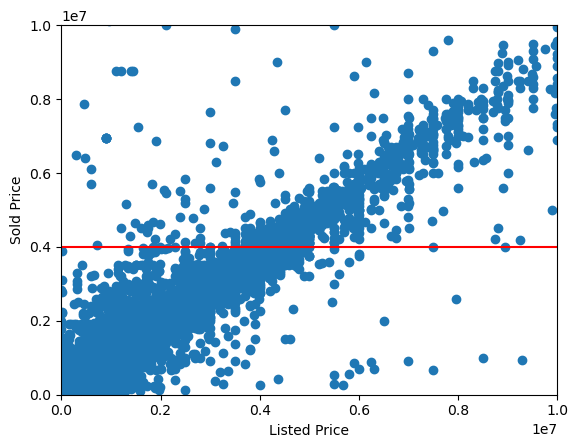

In [57]:
plt.scatter(df['Listed Price'],df['Sold Price'])
plt.hlines(y=4000000,xmin=0,xmax=10000000,colors='r')
plt.xlabel('Listed Price')
plt.ylabel('Sold Price')
plt.xlim(0,10000000)
plt.ylim(0,10000000)

Judging by both graphs we can use the the threshold of both 5M.

In [58]:
X_train_expensive = X_train[(((X_train['Tax assessed value'].isna()) & (X_train['Listed Price']>5*10**6))) | 
(X_train['Tax assessed value']>5*10**6)]

y_train_expensive = y_train.loc[X_train_expensive.index]

X_train_cheap = X_train[(((X_train['Tax assessed value'].isna()) & (X_train['Listed Price']<=5*10**6))) | 
(X_train['Tax assessed value']<=5*10**6)]

y_train_cheap = y_train.loc[X_train_cheap.index]

# len(X_train_lr_expensive), len(y_train_lr_expensive), len(X_train_lr_cheap), len(y_train_lr_cheap)

In [59]:
X_test_expensive = X_test[(((X_test['Tax assessed value'].isna()) & (X_test['Listed Price']>5*10**6))) | 
(X_test['Tax assessed value']>5*10**6)]

y_test_expensive = y_test.loc[X_test_expensive.index]

X_test_cheap = X_test[(((X_test['Tax assessed value'].isna()) & (X_test['Listed Price']<=5*10**6))) | 
(X_test['Tax assessed value']<=5*10**6)]

y_test_cheap = y_test.loc[X_test_cheap.index]


In [60]:
ratio_expensive = len(X_train_expensive)/len(X_train)
ratio_cheap = 1-ratio_expensive

ratio_expensive,ratio_cheap

(0.009433216516033833, 0.9905667834839662)

In [61]:
lr_expensive = LinearRegression()
lr_cheap = LinearRegression()

In [62]:
lr_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr_expensive)])

lr_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr_cheap)])

In [63]:
lr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False]}

In [64]:
gs_lr_expensive = GridSearchCV(estimator=lr_exp_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error',cv=2)

gs_lr_cheap = GridSearchCV(estimator=lr_cheap_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error',cv=2)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [65]:
gs_lr_expensive.fit(X_train_expensive,y_train_expensive)

/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [66]:
gs_lr_cheap.fit(X_train_cheap,y_train_cheap)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [67]:
best_estimator_lr_cheap = gs_lr_cheap.best_estimator_
best_estimator_lr_exp = gs_lr_expensive.best_estimator_
best_estimator_lr_cheap, best_estimator_lr_exp

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('nominalpipe',
                                                   Pipeline(steps=[('onehotimputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehotenc',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False)),
                                                                   ('onehotnorm',
                                                                    MaxAbsScaler())]),
                                                   ['Type', 'Heating', 'Cooling',
                                                    'Parking', 'Reg

In [68]:
best_estimator_lr_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_lr_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [69]:
y_pred_lr_exp = best_estimator_lr_exp.predict(X_test_expensive)
y_pred_lr_cheap = best_estimator_lr_cheap.predict(X_test_cheap)

In [91]:
logrmse_lr_cheap,rmse_lr_cheap = logrmse(y_test_cheap,y_pred_lr_cheap), mean_squared_error(y_test_cheap,y_pred_lr_cheap,squared=False)
logrmse_lr_cheap,rmse_lr_cheap

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 27552232.958691236)

In [92]:
logrmse_lr_exp,rmse_lr_exp = logrmse(y_test_expensive,y_pred_lr_exp), mean_squared_error(y_test_expensive,y_pred_lr_exp,squared=False)
logrmse_lr_exp,rmse_lr_exp

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 5087087.006984416)

In [93]:
(rmse_lr_cheap**2+rmse_lr_exp**2)**0.5

28017922.75002951

Just by putting outliers in a different estimator, we lowered our RMSE by about 25%

# 2nd Model - Elastic Net

For this model we will keep using the divided data but we introduce regularization

In [73]:
en_cheap = ElasticNet(max_iter=100000,random_state=19)
en_exp = ElasticNet(max_iter=100000,random_state=19)

In [74]:
en_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',en_exp)])

en_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',en_cheap)])

In [75]:
en_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[0.1,0.5,1,5,10],
                 'model__l1_ratio':[0.1,0.25,0.5,0.75,0.9]}

In [76]:
gs_en_expensive = GridSearchCV(estimator=en_exp_pipeline, 
                               param_grid=en_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_en_cheap = GridSearchCV(estimator=en_cheap_pipeline, 
                           param_grid=en_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [77]:
gs_en_expensive.fit(X_train_expensive,y_train_expensive)

/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3646927.622 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4438698.811 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-3728580.900 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4418479.693 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3685596.114 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4457557.189 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-3781862.417 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4437531.298 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3795077.961 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4502528.691 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-3922813.420 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4483091.052 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4040308.683 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4582330.883 total time=   0.2s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4215249.772 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4563051.441 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4445409.268 total time=   0.3s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4706281.032 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4670711.676 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4682778.548 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3967393.779 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4536803.372 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4160149.929 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4532372.979 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3989190.304 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4542031.929 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4195064.764 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4538137.905 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4058717.930 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4565524.993 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4287566.089 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4562087.174 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4239131.528 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4627230.755 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4490372.538 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4621525.265 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4577666.631 total time=   0.2s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4742054.001 total time=   0.2s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4842642.692 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4727771.326 total time=   0.2s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3689309.148 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4487296.823 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-3675491.151 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4473716.944 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3649071.330 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4448447.151 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-3641300.553 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4433692.214 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3589707.243 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4399893.912 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-3599804.773 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4382319.424 total time=   0.2s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-3597048.489 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4410031.281 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-3652790.311 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4389834.236 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-3795071.276 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4502530.921 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-3922805.537 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4483093.221 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4122495.215 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4861872.087 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4173505.280 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4859741.924 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4062369.483 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4775146.452 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4126951.836 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4771439.623 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3976226.177 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4636949.590 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4075778.614 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4630898.781 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-3944195.122 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4540413.926 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4109433.446 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4534834.650 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4058711.349 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4565526.353 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4287558.690 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4562088.629 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3904624.391 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4739893.517 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-3874646.604 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4726797.293 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3839135.727 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4657158.550 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-3812723.595 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4644784.867 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3715947.154 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4514893.996 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-3699083.463 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4501870.139 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-3589705.609 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4399894.971 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-3599803.019 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4382320.506 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-3628006.058 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4428581.829 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-3701229.881 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4408305.917 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4515670.875 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-5359103.424 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4528068.041 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-5362258.742 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4382535.095 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-5199720.239 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4403250.876 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-5201953.989 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4164325.111 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4919638.241 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4208168.869 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4918482.984 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-3976224.007 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4636950.410 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4075776.251 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4630899.488 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-3957622.383 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4535894.928 total time=   0.2s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4142051.967 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4531102.107 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-4828226.980 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-5934653.444 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-4783220.066 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-5902509.709 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4689858.616 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-5766780.759 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-4644149.224 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-5735652.914 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4410335.770 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-5413770.592 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4365818.388 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-5387286.598 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4039254.738 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4918197.500 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4003508.955 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4902089.127 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-3715942.419 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4514894.981 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-3699078.147 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4501870.833 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-7064113.309 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-7982633.522 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-7045455.616 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-7972098.769 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-6648457.066 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-7575249.951 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-6630109.973 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-7566733.542 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-5825931.584 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-6756305.648 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-5810760.717 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-6753109.149 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4823350.498 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-5707914.612 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4823543.477 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-5711146.957 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4164319.989 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4919639.968 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4208162.746 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4918484.645 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-5378670.624 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-6568538.053 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-5342157.266 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-6539039.671 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-5234969.610 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-6407402.112 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-5195545.768 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-6376343.457 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-4910696.866 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-6032824.841 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-4866437.526 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-6000441.550 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-4410337.065 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-5413772.661 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-4365819.645 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-5387288.485 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-3945373.745 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4792998.744 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-3913463.073 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4779167.249 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-8745669.178 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-9607847.344 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-8729774.844 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-9593913.349 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-8303149.899 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-9182693.100 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-8286118.380 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=median;, score=-9168966.214 total time=   0.2s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-7313517.727 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-8225672.273 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-7294933.295 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.5, preprocess__numericpipe__numimputer__strategy=median;, score=-8214161.353 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-5825936.647 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=mean;, score=-6756311.005 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-5810765.780 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.75, preprocess__numericpipe__numimputer__strategy=median;, score=-6753114.418 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-4604246.805 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=mean;, score=-5461889.806 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-4612355.775 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, model__l1_ratio=0.9, preprocess__numericpipe__numimputer__strategy=median;, score=-5465309.478 total time=   0.1s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        ElasticNet(max_iter=100000,
                                                   random_state=19))]),
             param_grid={'model__alpha': [0.1, 0.5, 1, 5, 10],
                         'model__fit_intercept': [True, False],
                         'model__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [78]:
gs_en_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-1066008.597 total time=   1.0s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=mean;, score=-2177104.989 total time=   1.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-1068170.177 total time=   1.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.1, preprocess__numericpipe__numimputer__strategy=median;, score=-2184473.238 total time=   1.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, preprocess__numericpipe__numimputer__strategy=mean;, score=-1064896.193 total time=   1.0s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, model__l1_ratio=0.25, pr

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        ElasticNet(max_iter=100000,
                                                   random_state=19))]),
             param_grid={'model__alpha': [0.1, 0.5, 1, 5, 10],
                         'model__fit_intercept': [True, False],
                         'model__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [80]:
best_estimator_en_cheap = gs_en_cheap.best_estimator_
best_estimator_en_exp = gs_en_expensive.best_estimator_
best_estimator_en_cheap, best_estimator_en_exp

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('nominalpipe',
                                                   Pipeline(steps=[('onehotimputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehotenc',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False)),
                                                                   ('onehotnorm',
                                                                    MaxAbsScaler())]),
                                                   ['Type', 'Heating', 'Cooling',
                                                    'Parking', 'Reg

In [81]:
best_estimator_en_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_en_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 ElasticNet(alpha=1, l1_ratio=0.75, max_iter=100000,
                            random_state=19))])

In [82]:
y_pred_en_exp = best_estimator_en_exp.predict(X_test_expensive)
y_pred_en_cheap = best_estimator_en_cheap.predict(X_test_cheap)

In [86]:
logrmse_en_cheap,rmse_en_cheap = logrmse(y_test_cheap,y_pred_en_cheap), mean_squared_error(y_test_cheap,y_pred_en_cheap,squared=False)
logrmse_en_cheap,rmse_en_cheap

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 14701118.446155887)

In [87]:
logrmse_en_exp,rmse_en_exp = logrmse(y_test_expensive,y_pred_en_exp), mean_squared_error(y_test_expensive,y_pred_en_exp,squared=False)
logrmse_en_exp,rmse_en_exp

(0.33896595190279166, 3959709.8115433133)

In [89]:
(rmse_en_cheap**2+rmse_en_exp**2)**0.5

15225051.243248321

# 3rd Model - Lasso Regressor

In [108]:
lasso_cheap = Lasso(max_iter=100000,random_state=19)
lasso_exp = Lasso(max_iter=100000,random_state=19)

In [109]:
lasso_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',lasso_exp)])

lasso_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',lasso_cheap)])

In [110]:
lasso_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[0.01,0.05,0.1,0.5,1,5,10,50,100]}

In [111]:
gs_lasso_expensive = GridSearchCV(estimator=lasso_exp_pipeline, 
                               param_grid=lasso_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_lasso_cheap = GridSearchCV(estimator=lasso_cheap_pipeline, 
                           param_grid=lasso_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [112]:
gs_lasso_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.892e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8418347.846 total time=   6.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7213915.452 total time=   6.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8101321.756 total time=   6.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7136953.011 total time=   6.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.747e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8464371.968 total time=   6.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.460e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7739516.490 total time=   6.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.648e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8158075.949 total time=   6.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.359e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7686601.197 total time=   9.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.892e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8416767.956 total time=  10.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7224106.691 total time=   9.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8099823.266 total time=   8.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7148223.235 total time=   7.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.748e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8462821.377 total time=   7.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.460e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7688102.145 total time=   7.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.648e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8156615.873 total time=   7.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.360e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7634560.556 total time=   8.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.893e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8415155.114 total time=   8.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7238531.714 total time=   8.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e+13, tolerance: 1.120e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8098330.491 total time=   7.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.763e+13, tolerance: 7.907e+11
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7164007.841 total time=   8.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.748e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8461250.117 total time=   7.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.460e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7629120.113 total time=   7.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.648e+13, tolerance: 3.233e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8155179.940 total time=   7.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.360e+13, tolerance: 2.921e+12
  model = cd_fast.enet_coordinate_descent(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7574815.610 total time=   7.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8413996.553 total time=   6.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7271503.034 total time=   3.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8098282.745 total time=   6.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7203087.272 total time=   3.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8460130.082 total time=   6.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7595709.067 total time=   3.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8155194.935 total time=   6.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7553577.378 total time=   3.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8412968.068 total time=   3.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7270136.720 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8097450.414 total time=   3.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7201702.136 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8459077.172 total time=   3.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7594255.992 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8154334.561 total time=   3.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7550324.166 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8404275.454 total time=   1.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7295617.487 total time=   0.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8090402.733 total time=   1.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7233466.468 total time=   0.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8450639.061 total time=   2.0s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7656215.126 total time=   1.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8147487.659 total time=   1.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7625164.258 total time=   1.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8393280.228 total time=   2.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7368898.990 total time=   0.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8081489.013 total time=   1.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7319785.584 total time=   0.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8440127.999 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7782725.227 total time=   1.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8139060.405 total time=   1.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7713050.770 total time=   1.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8305412.295 total time=   1.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7409697.841 total time=   0.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-8010336.386 total time=   1.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7337959.873 total time=   0.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8357249.949 total time=   1.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7636142.602 total time=   0.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-8072197.436 total time=   1.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7575079.905 total time=   0.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8201277.729 total time=   1.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7269589.233 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7924563.589 total time=   1.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7203428.396 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8257645.467 total time=   1.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7465498.206 total time=   0.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7991401.843 total time=   1.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7429353.027 total time=   0.6s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Lasso(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                                          100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [113]:
gs_lasso_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-1045483.358 total time=  11.6s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-2469333.515 total time=  17.0s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-1047266.552 total time=  10.9s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-2475998.418 total time=  16.9s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-1045511.278 total time=  15.3s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-2466306.632 total time=  15.7s
[CV 1/2] END model__alpha=0.01, m

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Lasso(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                                          100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [114]:
best_estimator_lasso_cheap = gs_lasso_cheap.best_estimator_
best_estimator_lasso_exp = gs_lasso_expensive.best_estimator_
best_estimator_lasso_cheap, best_estimator_lasso_exp

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('nominalpipe',
                                                   Pipeline(steps=[('onehotimputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehotenc',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False)),
                                                                   ('onehotnorm',
                                                                    MaxAbsScaler())]),
                                                   ['Type', 'Heating', 'Cooling',
                                                    'Parking', 'Reg

In [115]:
best_estimator_lasso_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_lasso_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', Lasso(alpha=100, max_iter=100000, random_state=19))])

In [116]:
y_pred_lasso_exp = best_estimator_lasso_exp.predict(X_test_expensive)
y_pred_lasso_cheap = best_estimator_lasso_cheap.predict(X_test_cheap)

In [117]:
logrmse_lasso_cheap,rmse_lasso_cheap = logrmse(y_test_cheap,y_pred_lasso_cheap), mean_squared_error(y_test_cheap,y_pred_lasso_cheap,squared=False)
logrmse_lasso_cheap,rmse_lasso_cheap

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 27551775.471799314)

In [118]:
logrmse_lasso_exp,rmse_lasso_exp = logrmse(y_test_expensive,y_pred_lasso_exp), mean_squared_error(y_test_expensive,y_pred_lasso_exp,squared=False)
logrmse_lasso_exp,rmse_lasso_exp

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 5038534.43426243)

In [119]:
(rmse_lasso_cheap**2+rmse_lasso_exp**2)**0.5

28008697.950702574

# 4th Model - Ridge Regressor

In [120]:
ridge_cheap = Ridge(max_iter=100000,random_state=19)
ridge_exp = Ridge(max_iter=100000,random_state=19)

In [121]:
ridge_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',ridge_exp)])

ridge_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',ridge_cheap)])

In [122]:
ridge_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[0.01,0.05,0.1,0.5,1,5,10,50,100]}

In [123]:
gs_ridge_expensive = GridSearchCV(estimator=ridge_exp_pipeline, 
                               param_grid=ridge_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_ridge_cheap = GridSearchCV(estimator=ridge_cheap_pipeline, 
                           param_grid=ridge_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [124]:
gs_ridge_expensive.fit(X_train_expensive,y_train_expensive)

/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7374375.140 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-6465488.452 total time=   0.1s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7286199.637 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-6375801.994 total time=   0.1s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7373263.360 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-6449335.121 total time=   0.1s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-7282888.718 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-6360427.790 total time=   0.1s
[CV 1/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-6257961.785 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-5737456.547 total time=   0.1s
[CV 1/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-6408349.793 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-5667902.754 total time=   0.1s
[CV 1/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-6242415.084 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-5735762.310 total time=   0.2s
[CV 1/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-6389727.799 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.05, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-5666029.602 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-5836244.047 total time=   0.1s
[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-5468680.585 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-6062815.210 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-5408256.830 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-5831979.705 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-5477056.599 total time=   0.1s
[CV 1/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-6055142.898 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-5417153.305 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-5074770.175 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4968127.885 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-5343783.049 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4928946.330 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-5139460.497 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4995205.275 total time=   0.1s
[CV 1/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-5414178.747 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=0.5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4960528.718 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4732864.326 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4810348.669 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4983229.489 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4780736.544 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4831946.997 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4842313.612 total time=   0.1s
[CV 1/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-5103019.536 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=1, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4819564.438 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-3996981.620 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4569246.436 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4164968.199 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4550084.577 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4205404.476 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4616020.030 total time=   0.1s
[CV 1/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4454134.800 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__alpha=5, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4610935.854 total time=   0.1s
[CV 1/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-3762218.620 total time=   0.1s
[CV 2/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4490015.449 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-3881571.370 total time=   0.1s
[CV 2/2] END model__alpha=10, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4470419.839 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4036908.006 total time=   0.1s
[CV 2/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4557837.724 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4260312.246 total time=   0.1s
[CV 2/2] END model__alpha=10, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4554397.148 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-3601511.435 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4408328.676 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-3606051.676 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4391489.461 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-3993957.626 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4667779.222 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4083383.348 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4662168.262 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-3746487.384 total time=   0.1s
[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4548103.153 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-3726711.529 total time=   0.1s
[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4535521.559 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4214528.420 total time=   0.1s
[CV 2/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4986855.294 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4251359.456 total time=   0.1s
[CV 2/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=median;, score=-4986725.483 total time=   0.1s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Ridge(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                                          100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [125]:
gs_ridge_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-1045483.370 total time=   0.6s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-2469338.258 total time=   0.7s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-1047266.588 total time=   0.7s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-2476003.206 total time=   0.8s
[CV 1/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-1045511.043 total time=   0.7s
[CV 2/2] END model__alpha=0.01, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-2466310.578 total time=   0.7s
[CV 1/2] END model__alpha=0.01, m

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Ridge(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                                          100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [126]:
best_estimator_ridge_cheap = gs_ridge_cheap.best_estimator_
best_estimator_ridge_exp = gs_ridge_expensive.best_estimator_
best_estimator_ridge_cheap, best_estimator_ridge_exp

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('nominalpipe',
                                                   Pipeline(steps=[('onehotimputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehotenc',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False)),
                                                                   ('onehotnorm',
                                                                    MaxAbsScaler())]),
                                                   ['Type', 'Heating', 'Cooling',
                                                    'Parking', 'Reg

In [127]:
best_estimator_ridge_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_ridge_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', Ridge(alpha=50, max_iter=100000, random_state=19))])

In [128]:
y_pred_ridge_exp = best_estimator_ridge_exp.predict(X_test_expensive)
y_pred_ridge_cheap = best_estimator_ridge_cheap.predict(X_test_cheap)

In [129]:
logrmse_ridge_cheap,rmse_ridge_cheap = logrmse(y_test_cheap,y_pred_ridge_cheap), mean_squared_error(y_test_cheap,y_pred_ridge_cheap,squared=False)
logrmse_ridge_cheap,rmse_ridge_cheap

/tmp/ipykernel_323893/1272647283.py:4: RuntimeWarning: invalid value encountered in log
  log1 = log((y_pred))


(nan, 27552179.002594136)

In [130]:
logrmse_ridge_exp,rmse_ridge_exp = logrmse(y_test_expensive,y_pred_ridge_exp), mean_squared_error(y_test_expensive,y_pred_ridge_exp,squared=False)
logrmse_ridge_exp,rmse_ridge_exp

(0.33576076640560826, 3801175.5459188353)

In [131]:
(rmse_ridge_cheap**2+rmse_ridge_exp**2)**0.5

27813153.422830008

# 5th Model - Random Forests

In [132]:
rf_cheap = RandomForestRegressor(random_state=19)
rf_exp = RandomForestRegressor(random_state=19)

In [133]:
rf_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_exp)])

rf_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_cheap)])

In [134]:
rf_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__n_estimators':[25,50,100,150],
                 'model__max_depth':[10,15,20,25]}

In [135]:
gs_rf_expensive = GridSearchCV(estimator=rf_exp_pipeline, 
                               param_grid=rf_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_rf_cheap = GridSearchCV(estimator=rf_cheap_pipeline, 
                           param_grid=rf_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [136]:
gs_rf_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3448048.287 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3574498.632 total time=   0.1s
[CV 1/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3419122.154 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3647652.905 total time=   0.1s
[CV 1/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3392827.091 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3552689.858 total time=   0.2s
[CV 1/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3338132.638 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3642926.869 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=10, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3425173.292 total time=   0.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3553017.501 total time=   0.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=10, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3413601.822 total time=   0.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3586213.071 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=10, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3480624.881 total time=   0.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3566833.468 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=10, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3465163.635 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=10, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3620047.390 total time=   0.5s
[CV 1/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3479375.646 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3597126.025 total time=   0.1s
[CV 1/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3432006.165 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3570349.929 total time=   0.1s
[CV 1/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3390487.237 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3615385.982 total time=   0.2s
[CV 1/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3353790.669 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3542014.495 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=15, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3492889.023 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3590859.763 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=15, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3405943.347 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3564235.147 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=15, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3523327.322 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3595760.723 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=15, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3441787.692 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=15, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3562728.799 total time=   0.5s
[CV 1/2] END model__max_depth=20, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3535618.704 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3594941.594 total time=   0.1s
[CV 1/2] END model__max_depth=20, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3504405.898 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3579406.283 total time=   0.1s
[CV 1/2] END model__max_depth=20, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3437509.534 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3617995.176 total time=   0.2s
[CV 1/2] END model__max_depth=20, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3367920.196 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3549093.954 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=20, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3493124.989 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3585406.619 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=20, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3379614.159 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3563151.299 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=20, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3520791.744 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3586808.511 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=20, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3441541.660 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=20, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3573230.508 total time=   0.5s
[CV 1/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3535618.704 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3594941.594 total time=   0.1s
[CV 1/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3504405.898 total time=   0.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3579406.283 total time=   0.1s
[CV 1/2] END model__max_depth=25, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3437509.534 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3617995.176 total time=   0.2s
[CV 1/2] END model__max_depth=25, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3367920.196 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3549093.954 total time=   0.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=25, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3493124.989 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3585406.619 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=25, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3379614.159 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3563151.299 total time=   0.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=25, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3520791.744 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3586808.511 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__max_depth=25, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3441541.660 total time=   0.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__max_depth=25, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3573230.508 total time=   0.5s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=19))]),
             param_grid={'model__max_depth': [10, 15, 20, 25],
                         'model__n_estimators': [25, 50, 100, 150],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [137]:
gs_rf_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-860371.837 total time=   5.3s
[CV 2/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-527807.425 total time=   5.3s
[CV 1/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-857024.719 total time=   5.3s
[CV 2/2] END model__max_depth=10, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-546067.820 total time=   5.2s
[CV 1/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-857726.672 total time=  10.0s
[CV 2/2] END model__max_depth=10, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-544792.741 total time=  10.1s
[CV 1/2] END model__max_depth=10, model__n_esti

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('no...
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=19))]),
             param_grid={'model__max_depth': [10, 15, 20, 25],
                         'model__n_estimators': [25, 50, 100, 150],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [138]:
best_estimator_rf_cheap = gs_rf_cheap.best_estimator_
best_estimator_rf_exp = gs_rf_expensive.best_estimator_
best_estimator_rf_cheap, best_estimator_rf_exp

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('nominalpipe',
                                                   Pipeline(steps=[('onehotimputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('onehotenc',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore',
                                                                                  sparse_output=False)),
                                                                   ('onehotnorm',
                                                                    MaxAbsScaler())]),
                                                   ['Type', 'Heating', 'Cooling',
                                                    'Parking', 'Reg

In [139]:
best_estimator_rf_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_rf_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('o...
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=50,
                                       random_state=19))])

In [140]:
y_pred_rf_exp = best_estimator_rf_exp.predict(X_test_expensive)
y_pred_rf_cheap = best_estimator_rf_cheap.predict(X_test_cheap)

In [141]:
logrmse_rf_cheap,rmse_rf_cheap = logrmse(y_test_cheap,y_pred_rf_cheap), mean_squared_error(y_test_cheap,y_pred_rf_cheap,squared=False)
logrmse_rf_cheap,rmse_rf_cheap

(0.20946782723039464, 700941.6987402212)

In [142]:
logrmse_rf_exp,rmse_rf_exp = logrmse(y_test_expensive,y_pred_rf_exp), mean_squared_error(y_test_expensive,y_pred_rf_exp,squared=False)
logrmse_rf_exp,rmse_rf_exp

(0.26225370797301417, 3151143.1738909464)

In [143]:
(rmse_rf_cheap**2 + rmse_rf_exp**2)**0.5

3228160.8645469225

In [144]:
(logrmse_rf_cheap**2 + logrmse_rf_exp**2)**0.5

0.3356393570340306

# 6th Model - Adaboost

In [147]:
ada_cheap = AdaBoostRegressor(estimator = RandomForestRegressor(max_depth=20), random_state=19)
ada_exp = AdaBoostRegressor(estimator = RandomForestRegressor(max_depth=15), random_state=19)

In [148]:
ada_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',ada_exp)])

ada_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',ada_cheap)])

In [153]:
ada_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__n_estimators':[25,50,100,150,200],
                 'model__learning_rate':[0.1,1,10]}

In [154]:
gs_ada_expensive = GridSearchCV(estimator=ada_exp_pipeline, 
                               param_grid=ada_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_ada_cheap = GridSearchCV(estimator=ada_cheap_pipeline, 
                           param_grid=ada_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [ ]:
gs_ada_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3589530.220 total time=   6.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3503953.137 total time=   6.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3525882.667 total time=   6.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3516206.806 total time=   6.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3578487.708 total time=  12.0s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3557513.412 total time=  13.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3472547.637 total time=  12.8s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3609545.897 total time=  12.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3547935.986 total time=  24.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3585099.429 total time=  26.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3415203.805 total time=  26.0s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3615164.537 total time=  25.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3536897.205 total time=  36.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3594010.151 total time=  38.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3419313.895 total time=  36.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3642517.908 total time=  36.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=mean;, score=-3525603.953 total time=  47.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=mean;, score=-3594686.697 total time=  48.0s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=0.1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=median;, score=-3429733.542 total time=  47.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=0.1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=median;, score=-3642497.680 total time=  49.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3460971.255 total time=   6.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-3612033.577 total time=   6.0s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3343001.378 total time=   5.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3661363.364 total time=   5.7s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3556158.783 total time=  10.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=mean;, score=-3596938.919 total time=  11.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3306810.066 total time=  10.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3638358.248 total time=  11.5s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3508221.181 total time=  20.3s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=mean;, score=-3615878.901 total time=  24.1s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3347078.740 total time=  22.2s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3642297.074 total time=  22.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3482716.821 total time=  31.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=mean;, score=-3618162.419 total time=  31.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3377416.991 total time=  33.6s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=150, preprocess__numericpipe__numimputer__strategy=median;, score=-3644360.831 total time=  35.9s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=mean;, score=-3474093.983 total time=  40.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/2] END model__learning_rate=1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=mean;, score=-3621035.247 total time=  43.4s


/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/2] END model__learning_rate=1, model__n_estimators=200, preprocess__numericpipe__numimputer__strategy=median;, score=-3406809.531 total time=  45.8s


In [ ]:
gs_ada_cheap.fit(X_train_cheap,y_train_cheap)

In [ ]:
best_estimator_ada_cheap = gs_ada_cheap.best_estimator_
best_estimator_ada_exp = gs_ada_expensive.best_estimator_
best_estimator_ada_cheap, best_estimator_ada_exp

In [ ]:
best_estimator_ada_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_ada_exp.fit(X_train_expensive,y_train_expensive)

In [ ]:
y_pred_ada_exp = best_estimator_ada_exp.predict(X_test_expensive)
y_pred_ada_cheap = best_estimator_ada_cheap.predict(X_test_cheap)

In [ ]:
logrmse_ada_cheap,rmse_ada_cheap = logrmse(y_test_cheap,y_pred_ada_cheap), mean_squared_error(y_test_cheap,y_pred_ada_cheap,squared=False)
logrmse_ada_cheap,rmse_ada_cheap

In [ ]:
logrmse_ada_exp,rmse_ada_exp = logrmse(y_test_expensive,y_pred_ada_exp), mean_squared_error(y_test_expensive,y_pred_ada_exp,squared=False)
logrmse_ada_exp,rmse_ada_exp

In [ ]:
(rmse_ada_cheap**2 + rmse_ada_exp**2)**0.5

In [ ]:
(logrmse_ada_cheap**2 + logrmse_ada_exp**2)**0.5

# 7th Model - Gradient Boosting

In [ ]:
grad_cheap = GradientBoostingRegressor(n_iter_no_change=10,validation_fraction=0.2 ,random_state=19)
grad_exp = GradientBoostingRegressor(n_iter_no_change=10,validation_fraction=0.2 ,random_state=19)

In [ ]:
grad_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_exp)])

grad_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_cheap)])

In [ ]:
grad_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__n_estimators':[25,50,100,150,200],
                 'model__learning_rate':[0.1,1,10],
                 'model__max_depth':[2,3,4,5,10]}

In [ ]:
gs_grad_expensive = GridSearchCV(estimator=grad_exp_pipeline, 
                               param_grid=grad_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_grad_cheap = GridSearchCV(estimator=grad_cheap_pipeline, 
                           param_grid=grad_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [ ]:
gs_grad_expensive.fit(X_train_expensive,y_train_expensive)

In [ ]:
gs_grad_cheap.fit(X_train_cheap,y_train_cheap)

In [ ]:
best_estimator_grad_cheap = gs_grad_cheap.best_estimator_
best_estimator_grad_exp = gs_grad_expensive.best_estimator_
best_estimator_grad_cheap, best_estimator_grad_exp

In [ ]:
best_estimator_grad_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_grad_exp.fit(X_train_expensive,y_train_expensive)

In [ ]:
y_pred_grad_exp = best_estimator_grad_exp.predict(X_test_expensive)
y_pred_grad_cheap = best_estimator_grad_cheap.predict(X_test_cheap)

In [ ]:
logrmse_grad_cheap,rmse_grad_cheap = logrmse(y_test_cheap,y_pred_grad_cheap), mean_squared_error(y_test_cheap,y_pred_grad_cheap,squared=False)
logrmse_grad_cheap,rmse_grad_cheap

In [ ]:
logrmse_grad_exp,rmse_grad_exp = logrmse(y_test_expensive,y_pred_grad_exp), mean_squared_error(y_test_expensive,y_pred_grad_exp,squared=False)
logrmse_grad_exp,rmse_grad_exp

In [ ]:
(rmse_grad_cheap**2 + rmse_grad_exp**2)**0.5

In [ ]:
(logrmse_grad_cheap**2 + logrmse_grad_exp**2)**0.5

# 8th Model - XGBoost

In [ ]:
xgb_cheap = xgb.XGBRegressor(random_state=19)
xgb_exp = xgb.XGBRegressor(random_state=19)

In [ ]:
xgb_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_exp)])

xgb_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_cheap)])

In [ ]:
xgb_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                  'model__booster':['gbtree','gblinear','dart'],
                  'model__colsample_bylevel':[0.5,0,75,1],
                 'model__learning_rate':[0.1,0.5,1],
                 'model__max_depth':[10,15,20,30,40],
                 'model__n_estimators':[100,150,200,300],
                 'model__subsample':[0.25,0.5,0.75,1]}

In [ ]:
gs_xgb_expensive = GridSearchCV(estimator=xgb_exp_pipeline, 
                               param_grid=xgb_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_xgb_cheap = GridSearchCV(estimator=xgb_cheap_pipeline, 
                           param_grid=xgb_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=2, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [ ]:
gs_xgb_expensive.fit(X_train_expensive,y_train_expensive)

In [ ]:
gs_xgb_cheap.fit(X_train_cheap,y_train_cheap)

In [ ]:
best_estimator_xgb_cheap = gs_xgb_cheap.best_estimator_
best_estimator_xgb_exp = gs_xgb_expensive.best_estimator_
best_estimator_xgb_cheap, best_estimator_xgb_exp

In [ ]:
best_estimator_xgb_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_xgb_exp.fit(X_train_expensive,y_train_expensive)

In [ ]:
y_pred_xgb_exp = best_estimator_xgb_exp.predict(X_test_expensive)
y_pred_xgb_cheap = best_estimator_xgb_cheap.predict(X_test_cheap)

In [ ]:
logrmse_xgb_cheap,rmse_xgb_cheap = logrmse(y_test_cheap,y_pred_xgb_cheap), mean_squared_error(y_test_cheap,y_pred_xgb_cheap,squared=False)
logrmse_xgb_cheap,rmse_xgb_cheap

In [ ]:
logrmse_xgb_exp,rmse_xgb_exp = logrmse(y_test_expensive,y_pred_xgb_exp), mean_squared_error(y_test_expensive,y_pred_xgb_exp,squared=False)
logrmse_xgb_exp,rmse_xgb_exp

In [ ]:
(rmse_xgb_cheap**2 + rmse_xgb_exp**2)**0.5

In [ ]:
(logrmse_xgb_cheap**2 + logrmse_xgb_exp**2)**0.5

Results are as following:

|Model|RMSE (in Millions of Dollars)|Log RMSE|
|---|---|---|
|Linear Regression|36.43|-|
|Linear Regression - Expensive and Cheaper Houses|28.02 |-|
|Elastic Net|15.23 | -|
|Lasso|28.01 | -|
|Ridge|27.88 |- |
|Random Forests|3.23 |0.33 |
|AdaBoosting| | |
|Gradient Boosting| | |
|XGBoost| | |